In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from cirkit.templates import data_modalities, utils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

PIXEL_RANGE = 255
example_image = None

KERNEL_SIZE = (4, 4)
CELEBA_SIZE = (220, 180)
DEVICE = "cuda:6"
EPOCH = 5

## Data Preparation

Let's define a function to create and use patches of the base Dataset

torch.Size([3, 220, 180])


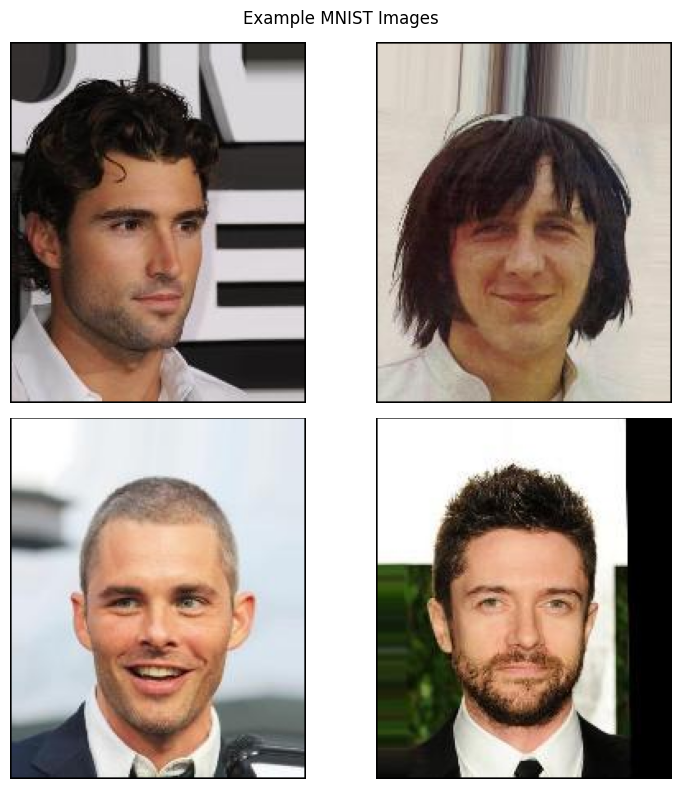

In [2]:
def patchify(kernel_size, stride, compile=True, contiguous_output=False):
    kh, kw = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
    sh, sw = (stride, stride) if isinstance(stride, int) else stride

    def _patchify(image: torch.Tensor):
        # Accept (C,H,W) or (B,C,H,W)

        # Ensure contiguous NCHW for predictable strides
        x = image.contiguous()  # (B,C,H,W)
        B, C, H, W = x.shape

        # Number of patches along H/W
        Lh = (H - kh) // sh + 1
        Lw = (W - kw) // sw + 1

        # Create a zero-copy view: (B, C, Lh, Lw, kh, kw)
        sN, sC, sH, sW = x.stride()
        patches = x.as_strided(
            size=(B, C, Lh, Lw, kh, kw),
            stride=(sN, sC, sH * sh, sW * sw, sH, sW),
        )
        # Reorder to (B, P, C, kh, kw) where P = Lh*Lw
        patches = patches.permute(0, 2, 3, 1, 4, 5).reshape(B * Lh * Lw, C, kh, kw)

        if contiguous_output:
            patches = (
                patches.contiguous()
            )  # materialize if the next ops need contiguous

        return patches

    if compile:
        _patchify = torch.compile(_patchify, fullgraph=True, dynamic=False)
    return _patchify


def plot_sample_images(dataloader, gridsize=2):
    global example_image
    # Get the first batch of images and labels
    images, label = next(iter(dataloader))
    example_image = images[0]
    print(example_image.shape)
    images = images[: gridsize**2]

    # Create a 3x3 subplot
    fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))

    # Plot each image
    for i, ax in enumerate(axes.flat):
        # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
        img = images[i, :, :, :].numpy().squeeze().transpose((1, 2, 0))

        # Display the image
        ax.imshow(img)
        ax.axis("off")  # Turn off axis

    # Adjust spacing between subplots
    fig.suptitle("Example MNIST Images")
    plt.tight_layout()
    plt.show()


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Pad(1),
        transforms.Lambda(lambda x: (PIXEL_RANGE * x).long()),
    ]
)

data_train = datasets.CelebA(
    "datasets", split="train", download=True, transform=transform
)
data_test = datasets.CelebA(
    "datasets", split="test", download=True, transform=transform
)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=12)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=12)
plot_sample_images(train_dataloader)

## Defining the Circuit

We want to create a factory to create the different circuit we will want to compare.

In [3]:
def patch_circuit_factory(kernel_size, region_graph, layer_type, num_units):
    return data_modalities.image_data(
        (3, *kernel_size),
        region_graph=region_graph,
        input_layer="categorical",
        num_input_units=num_units,
        sum_product_layer=layer_type,
        num_sum_units=num_units,
        sum_weight_param=utils.Parameterization(
            activation="softmax", initialization="normal"
        ),
    )


def base_circuit_factory(region_graph, layer_type, num_units):
    return data_modalities.image_data(
        (3, *CELEBA_SIZE),
        region_graph=region_graph,
        input_layer="categorical",
        num_input_units=num_units,
        sum_product_layer=layer_type,
        num_sum_units=num_units,
        sum_weight_param=utils.Parameterization(
            activation="softmax", initialization="normal"
        ),
    )

In [4]:
circuits = dict()
circuits["patch + tucker + quad-graph"] = patch_circuit_factory(
    KERNEL_SIZE, "quad-graph", "tucker", 64
)
circuits["base + cp + quad-graph"] = base_circuit_factory("quad-graph", "cp", 64)

## Training

In [ ]:
import random
import time

import pandas as pd
from cirkit.pipeline import compile
from tqdm import tqdm


def train_and_eval_circuit(cc, patch: bool):
    # Set some seeds
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    # torch.cuda.manual_seed(42)

    # Set the torch device to use
    device = torch.device(DEVICE)
    # Move the circuit to chosen device
    circuit = compile(cc)
    circuit = circuit.to(device)

    num_epochs = 1
    step_idx = 0
    running_loss = 0.0
    running_samples = 0
    stats = dict()

    stats["# trainable parameters"] = sum(
        p.numel() for p in circuit.parameters() if p.requires_grad
    )
    stats["train loss"] = []
    patch_fn = patchify(KERNEL_SIZE, KERNEL_SIZE)
    # Initialize a torch optimizer of your choice,
    #  e.g., Adam, by passing the parameters of the circuit
    optimizer = torch.optim.Adam(circuit.parameters(), lr=0.01)
    begin_train = time.time()
    for epoch_idx in range(num_epochs):
        for i, (batch, _) in tqdm(
            enumerate(train_dataloader), total=len(train_dataloader)
        ):
            # The circuit expects an input of shape (batch_dim, num_variables)
            if patch:
                batch = patch_fn(batch)
            BS = batch.shape[0]
            batch = batch.view(BS, -1).to(device)

            # Compute the log-likelihoods of the batch, by evaluating the circuit
            log_likelihoods = circuit(batch)

            # We take the negated average log-likelihood as loss
            loss = -torch.mean(log_likelihoods)
            loss.backward()
            # Update the parameters of the circuits, as any other model in PyTorch
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.detach() * len(batch)
            running_samples += len(batch)
            step_idx += 1
            if step_idx % 200 == 0:
                average_nll = running_loss / running_samples
                print(f"Step {step_idx}: Average NLL: {average_nll:.3f}")
                running_loss = 0.0
                running_samples = 0

                stats["train loss"].append(average_nll.cpu().item())
    end_train = time.time()

    with torch.no_grad():
        test_lls = 0.0

        for batch, _ in test_dataloader:
            # The circuit expects an input of shape (batch_dim, num_variables)
            if patch:
                batch = patch_fn(batch)
            BS = batch.shape[0]
            batch = batch.view(BS, -1).to(device)

            # Compute the log-likelihoods of the batch
            log_likelihoods = circuit(batch)

            # Accumulate the log-likelihoods
            test_lls += log_likelihoods.sum().item()

        # Compute average test log-likelihood and bits per dimension
        average_nll = -test_lls / len(data_test)
        bpd = average_nll / (torch.prod(example_image.shape[-3:]) * np.log(2.0))
        print(f"Average test LL: {average_nll:.3f}")
        print(f"Bits per dimension: {bpd:.3f}")

        stats["test loss"] = average_nll
        stats["test bits per dimension"] = bpd
    end_test = time.time()

    # Free GPU memory
    circuit = circuit.to("cpu")
    torch.cuda.empty_cache()

    stats["train loss (min)"] = min(stats["train loss"])
    stats["train time"] = end_train - begin_train
    stats["test time"] = end_test - end_train

    return stats


results = dict()
for k, cc in circuits.items():
    print('\nTraining circuit "%s"' % k)
    ctype = k.split("+")[0].strip()
    results[k] = train_and_eval_circuit(cc, patch=ctype == "patch")
    results[k]["type"] = k.split("+")[0].strip()
    results[k]["sum product layer"] = k.split("+")[1].strip()
    results[k]["structure"] = k.split("+")[2].strip()


Training circuit "patch + tucker + quad-graph"


  1%|██▊                                                                                                                                                                                           | 201/13565 [01:10<1:08:26,  3.25it/s]

Step 200: Average NLL: 249.485


  3%|█████▌                                                                                                                                                                                        | 400/13565 [02:11<1:25:48,  2.56it/s]

Step 400: Average NLL: 210.917


  4%|████████▍                                                                                                                                                                                     | 600/13565 [03:12<1:24:40,  2.55it/s]

Step 600: Average NLL: 196.925


  6%|███████████▏                                                                                                                                                                                  | 800/13565 [04:13<1:23:30,  2.55it/s]

Step 800: Average NLL: 192.240


  7%|█████████████▉                                                                                                                                                                               | 1000/13565 [05:22<1:23:01,  2.52it/s]

Step 1000: Average NLL: 189.724


  9%|████████████████▋                                                                                                                                                                            | 1200/13565 [06:28<1:25:37,  2.41it/s]

Step 1200: Average NLL: 187.447


 10%|██████████████████▎                                                                                                                                                                          | 1310/13565 [07:03<2:00:18,  1.70it/s]

In [ ]:
df = pd.DataFrame.from_dict(results, orient="index")
df = df.drop(columns="train loss")

df.index = df.index.map(lambda x: x.split("+")[0])
df["# trainable parameters"] = df["# trainable parameters"].map("{:,d}".format)
pd.options.display.float_format = "{:,.3f}".format
df["train time format"] = pd.to_datetime(df["train time"], unit="s").dt.strftime(
    "%m:%S"
)
df["test time format"] = pd.to_datetime(df["test time"], unit="s").dt.strftime("%m:%S")

df.sort_values("test bits per dimension")

,# trainable parameters,test loss,test bits per dimension,train loss (min),train time,test time,type,sum product layer,structure,train time format,test time format
base,"25,657,730",681.926,1.255,683.536,140.801,1.277,base,cp,quad-graph,01:20,01:01
base,"421,306,626",683.163,1.257,681.451,530.976,2.879,base,tucker,quad-graph,01:50,01:02
base,"19,259,456",684.707,1.260,686.227,104.214,1.119,base,cp,quad-tree-2,01:44,01:01
base,"19,259,778",689.319,1.268,676.182,121.753,1.206,base,cp.T,quad-graph,01:01,01:01
base,"217,845,760",690.699,1.271,688.059,273.444,1.982,base,tucker,quad-tree-2,01:33,01:01
base,"16,048,192",693.989,1.277,683.492,98.947,1.096,base,cp.T,quad-tree-2,01:38,01:01
patch,"377,474",723.323,1.331,14.849,95.649,2.056,patch,cp.T,quad-graph,01:35,01:02
patch,"319,552",729.018,1.342,14.960,82.122,1.094,patch,cp.T,quad-tree-2,01:22,01:01
patch,"508,546",731.456,1.346,15.045,94.729,1.252,patch,cp,quad-graph,01:34,01:01
patch,"385,088",734.023,1.351,15.079,83.818,1.131,patch,cp,quad-tree-2,01:23,01:01


In [ ]:
print(
    df[
        [
            "type",
            "sum product layer",
            "structure",
            "# trainable parameters",
            "test bits per dimension",
            "test loss",
            "train time format",
            "test time format",
        ]
    ]
    .sort_values("test bits per dimension")
    .to_latex(float_format="%.2f", escape=True, index=False)
)

\begin{tabular}{llllrrll}
\toprule
type & sum product layer & structure & \# trainable parameters & test bits per dimension & test loss & train time format & test time format \\
\midrule
base & cp & quad-graph & 25,657,730 & 1.25 & 681.93 & 01:20 & 01:01 \\
base & tucker & quad-graph & 421,306,626 & 1.26 & 683.16 & 01:50 & 01:02 \\
base & cp & quad-tree-2 & 19,259,456 & 1.26 & 684.71 & 01:44 & 01:01 \\
base & cp.T & quad-graph & 19,259,778 & 1.27 & 689.32 & 01:01 & 01:01 \\
base & tucker & quad-tree-2 & 217,845,760 & 1.27 & 690.70 & 01:33 & 01:01 \\
base & cp.T & quad-tree-2 & 16,048,192 & 1.28 & 693.99 & 01:38 & 01:01 \\
patch & cp.T & quad-graph & 377,474 & 1.33 & 723.32 & 01:35 & 01:02 \\
patch & cp.T & quad-tree-2 & 319,552 & 1.34 & 729.02 & 01:22 & 01:01 \\
patch & cp & quad-graph & 508,546 & 1.35 & 731.46 & 01:34 & 01:01 \\
patch & cp & quad-tree-2 & 385,088 & 1.35 & 734.02 & 01:23 & 01:01 \\
patch & tucker & quad-graph & 7,610,882 & 1.35 & 734.18 & 01:10 & 01:02 \\
patch & tucke